# Dependencies

In [1]:
# DEPENDENCIES
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import requests
from pprint import pprint
from config import api_key
import time
import seaborn as sns
import hvplot.pandas
import geopandas as gpd


# CSV to DFs
(load csv paths & read csv to DFs)

In [2]:
Mental_Disorders = Path("Resources/Mental health Depression disorder Data.csv")
Mental_Disorders_OGdf = pd.read_csv(Mental_Disorders, delimiter=',')

Pop = Path("Resources/World_Bank/Pop.csv")
Pop_OGdf = pd.read_csv(Pop, delimiter = ',')

Drugs_Gov_Benefits = Path("Resources/World_Health/Drugs_Gov_Benefits.csv")
Drugs_GovB_OGdf = pd.read_csv(Drugs_Gov_Benefits, delimiter=',')


/var/folders/m6/bhhzzj012vq18r_pf4rv2l640000gn/T/ipykernel_3197/2748840029.py:2: DtypeWarning: Columns (5,6) have mixed types. Specify dtype option on import or set low_memory=False.
  Mental_Disorders_OGdf = pd.read_csv(Mental_Disorders, delimiter=',')


# Prep DFs for Merge 
(column renames, dropna values, iloc rows, melts, column formatting)

In [3]:
# BROAD DFs
Mental_Disorders_df_torename = Mental_Disorders_OGdf.drop('index', axis=1)
Mental_Disorders_df_torowdrop = Mental_Disorders_df_torename.rename(columns={"Entity": "Country Name"})
Mental_Disorders_df_todropna = Mental_Disorders_df_torowdrop.iloc[0:6468]
Mental_Disorders_df = Mental_Disorders_df_todropna.dropna()
Drug_Disorder_df = Mental_Disorders_df[['Country Name', 'Year', 'Drug use disorders (%)']]

Pop_df_tomelt = Pop_OGdf[["Country Name", "2010", "2011", "2012", "2013", "2014", "2015", "2016", "2017"]]
Pop_df_todtopna = Pop_df_tomelt.melt(id_vars="Country Name", var_name = "Year", value_name = "Population")
Pop_df = Pop_df_todtopna.dropna()
Pop_df['Population'] = Pop_df["Population"].map("{:.0f}".format)
Pop_df['Population'] = Pop_df['Population'].astype(int)
Pop_df

Drugs_GovB_df= Drugs_GovB_OGdf[['Location', 'Period', 'Dim1', 'Value']]
Drugs_GovB_df['Period'].unique() # Only 2014 data, assume stable gov policy throughout period (address limitations later)
Drugs_GovB_torename = Drugs_GovB_df[['Location', 'Dim1', 'Value']]
Drugs_GovB = Drugs_GovB_torename.rename(columns={'Location': 'Country Name', 'Dim1': 'Government Benefit Type', 'Value': 'Government Benefit (Y/N)'})
Drugs_GovB


/var/folders/m6/bhhzzj012vq18r_pf4rv2l640000gn/T/ipykernel_3197/415288315.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Pop_df['Population'] = Pop_df["Population"].map("{:.0f}".format)
/var/folders/m6/bhhzzj012vq18r_pf4rv2l640000gn/T/ipykernel_3197/415288315.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Pop_df['Population'] = Pop_df['Population'].astype(int)


,Country Name,Government Benefit Type,Government Benefit (Y/N)
0,Afghanistan,Monetary support,No
1,Afghanistan,Non monetary support,No
2,Albania,Monetary support,No
3,Albania,Non monetary support,No
4,Algeria,Monetary support,No
...,...,...,...
383,United Kingdom of Great Britain and Northern I...,Non monetary support,Yes
384,United States of America,Monetary support,Yes
385,United States of America,Non monetary support,Yes
386,Uruguay,Non monetary support,Yes


In [4]:
Drugs_GovB_M = Drugs_GovB.loc[Drugs_GovB['Government Benefit Type'] == 'Monetary support']
Drugs_GovB_M = Drugs_GovB_M.rename(columns={'Government Benefit (Y/N)': 'Government Monetary Support'})
Drugs_GovB_M= Drugs_GovB_M[['Country Name', 'Government Monetary Support']]
Drugs_GovB_M

,Country Name,Government Monetary Support
0,Afghanistan,No
2,Albania,No
4,Algeria,No
6,Azerbaijan,No
8,Bahrain,No
...,...,...
375,Tajikistan,Yes
378,Trinidad and Tobago,Yes
380,United Arab Emirates,Yes
382,United Kingdom of Great Britain and Northern I...,Yes


In [5]:
Drugs_GovB_NM = Drugs_GovB.loc[Drugs_GovB['Government Benefit Type'] == 'Non monetary support']
Drugs_GovB_NM = Drugs_GovB_NM.rename(columns={'Government Benefit (Y/N)': 'Government Non-Monetary Support'})
Drugs_GovB_NM= Drugs_GovB_NM[['Country Name', 'Government Non-Monetary Support']]
Drugs_GovB_NM

,Country Name,Government Non-Monetary Support
1,Afghanistan,No
3,Albania,No
5,Algeria,No
7,Azerbaijan,No
9,Bahrain,No
...,...,...
381,United Arab Emirates,Yes
383,United Kingdom of Great Britain and Northern I...,Yes
385,United States of America,Yes
386,Uruguay,Yes


In [6]:
Drugs_GovB_MNM= pd.merge(Drugs_GovB_M, Drugs_GovB_NM, on = 'Country Name', how = 'inner')

Drugs_GovB_MNM = Drugs_GovB_MNM.replace('No data', pd.NA).dropna()

Drugs_GovB_MNM



,Country Name,Government Monetary Support,Government Non-Monetary Support
0,Afghanistan,No,No
1,Albania,No,No
2,Algeria,No,No
3,Azerbaijan,No,No
4,Bahrain,No,No
...,...,...,...
189,Tajikistan,Yes,Yes
190,Trinidad and Tobago,Yes,Yes
191,United Arab Emirates,Yes,Yes
192,United Kingdom of Great Britain and Northern I...,Yes,Yes


# Merge

In [7]:
# MERGING
Drug_Pop_df = pd.merge(Pop_df, Drug_Disorder_df, on = ['Country Name', 'Year'], how = 'inner')
Drug_GovB_Pop_df = pd.merge(Drug_Pop_df, Drugs_GovB_MNM, on = 'Country Name', how = 'inner')

In [8]:
# Column Calculations
Drug_Pop_df['Drug use disorders (%)'] = pd.to_numeric(Drug_Pop_df['Drug use disorders (%)'], errors='coerce')
Drug_Pop_df['Population'] = pd.to_numeric(Drug_Pop_df['Population'], errors='coerce')

Drug_Pop_df['Drug use disorders (#)'] = Drug_Pop_df['Drug use disorders (%)'] * Drug_Pop_df['Population']

Drug_Pop_df = Drug_Pop_df[Drug_Pop_df['Country Name'] != 'World']

Drug_Pop_df


,Country Name,Year,Population,Drug use disorders (%),Drug use disorders (#)
0,Afghanistan,2010,28189672,2.571349,7.248548e+07
1,Angola,2010,23364185,0.503415,1.176188e+07
2,Albania,2010,2913021,0.500270,1.457297e+06
3,Andorra,2010,71519,0.901630,6.448368e+04
4,United Arab Emirates,2010,8481771,3.059998,2.595420e+07
...,...,...,...,...,...
1330,Vanuatu,2017,290239,0.698906,2.028498e+05
1332,Samoa,2017,207630,0.844905,1.754276e+05
1333,South Africa,2017,56641209,0.921499,5.219482e+07
1334,Zambia,2017,17298054,0.515972,8.925312e+06


In [9]:
Drugs_GovB_Pop_df = Drug_GovB_Pop_df.replace('No data', pd.NA).dropna()

Drugs_GovB_Pop_df

,Country Name,Year,Population,Drug use disorders (%),Government Monetary Support,Government Non-Monetary Support
0,Afghanistan,2010,28189672,2.571349,No,No
1,Albania,2010,2913021,0.500270,No,No
2,Andorra,2010,71519,0.901630,Yes,Yes
3,United Arab Emirates,2010,8481771,3.059998,Yes,Yes
4,Australia,2010,22031750,1.993151,Yes,Yes
...,...,...,...,...,...,...
971,Uruguay,2017,3422200,0.918533,No,Yes
972,Uzbekistan,2017,32388600,0.481220,No,Yes
973,Vanuatu,2017,290239,0.698906,No,No
974,Zambia,2017,17298054,0.515972,No,No


In [10]:
Drugs_GovB_Pop_df['Country Name'].unique()

array(['Afghanistan', 'Albania', 'Andorra', 'United Arab Emirates',
       'Australia', 'Austria', 'Azerbaijan', 'Burundi', 'Belgium',
       'Benin', 'Burkina Faso', 'Bangladesh', 'Bahrain',
       'Bosnia and Herzegovina', 'Belize', 'Brazil', 'Barbados', 'Bhutan',
       'Botswana', 'Central African Republic', 'Canada', 'Switzerland',
       'Chile', 'China', "Cote d'Ivoire", 'Colombia', 'Comoros',
       'Costa Rica', 'Cuba', 'Cyprus', 'Germany', 'Djibouti', 'Denmark',
       'Dominican Republic', 'Algeria', 'Ecuador', 'Spain', 'Ethiopia',
       'Finland', 'Fiji', 'France', 'Gabon', 'Georgia', 'Ghana', 'Greece',
       'Grenada', 'Guyana', 'Honduras', 'Croatia', 'Haiti', 'Hungary',
       'Indonesia', 'India', 'Ireland', 'Iraq', 'Iceland', 'Israel',
       'Italy', 'Jamaica', 'Jordan', 'Japan', 'Kazakhstan', 'Kenya',
       'Cambodia', 'Kiribati', 'Kuwait', 'Lebanon', 'Libya', 'Sri Lanka',
       'Lithuania', 'Latvia', 'Morocco', 'Madagascar', 'Mexico', 'Mali',
       'Malta', 'Mon

In [11]:
## Merged DF Country Count
len(Drugs_GovB_Pop_df['Country Name'].unique())

122

In [12]:
# Casting in Merged DF
Drug_Pop_df = Drug_Pop_df.astype({"Year": int}, errors='raise')
Drug_Pop_df.dtypes

Country Name               object
Year                        int64
Population                  int64
Drug use disorders (%)    float64
Drug use disorders (#)    float64
dtype: object

# Create CSV of Merged DF

In [13]:
Drugs_GovB_Pop_df.to_csv("Output_Data/Drug_Use_Disorders.csv")

# Drug Disorder Anlaysis

### Drug Disorder Trend

In [14]:
Drug_Yrs_df = Drug_Pop_df[['Year', 'Population', 'Drug use disorders (#)']].groupby('Year').sum()
Drug_Yrs_df['Global drug use disorder (%)'] = Drug_Yrs_df['Drug use disorders (#)'] / Drug_Yrs_df['Population']
Drug_Yrs_df.rename(columns={'Drug use disorders (#)': 'Global drug use disorder (#)'})

,Population,Global drug use disorder (#),Global drug use disorder (%)
Year,,,
2010,6209732805,5.694963e+09,0.917103
2011,6283817129,5.776554e+09,0.919275
2012,6361533506,5.872257e+09,0.923088
2013,6440423283,5.978359e+09,0.928256
2014,6518739719,6.093057e+09,0.934699
2015,6595382141,6.213692e+09,0.942128
2016,6671628033,6.339670e+09,0.950243
2017,6747925403,6.472665e+09,0.959208


<function matplotlib.pyplot.show(close=None, block=None)>

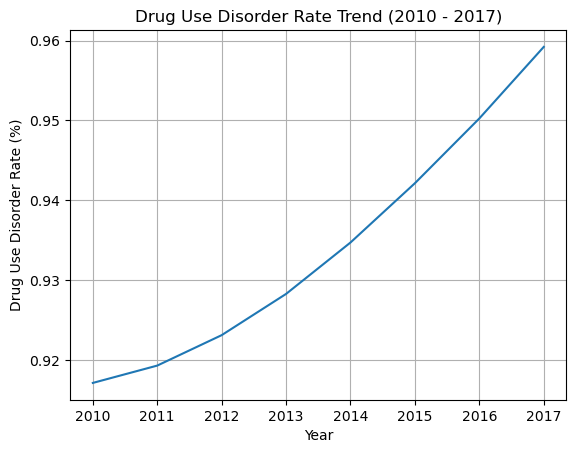

In [15]:
# Drugs
x_axis = Drug_Yrs_df.index
Drug_trend = Drug_Yrs_df['Global drug use disorder (%)']
plt.plot(x_axis, Drug_trend)
plt.ylabel("Drug Use Disorder Rate (%)")
plt.xlabel("Year")
plt.title("Drug Use Disorder Rate Trend (2010 - 2017)")
plt.grid()
plt.savefig("Output_PNG/Drug_Trend.png")
plt.show

### Sorted Mean Disorder Rates by Country

In [16]:
Drug_Country_df = Drug_Pop_df.groupby("Country Name").mean().sort_values("Drug use disorders (%)", ascending=False)
Drug_Country_df

,Year,Population,Drug use disorders (%),Drug use disorders (#)
Country Name,,,,
United States,2013.5,3.172709e+08,3.174581,1.008020e+09
United Arab Emirates,2013.5,8.786150e+06,3.007827,2.641824e+07
Libya,2013.5,6.185708e+06,2.552003,1.578635e+07
Afghanistan,2013.5,3.202448e+07,2.548328,8.153747e+07
Canada,2013.5,3.524174e+07,2.215271,7.809234e+07
...,...,...,...,...
Chad,2013.5,1.346250e+07,0.446516,6.017746e+06
Guinea,2013.5,1.122171e+07,0.443142,4.977394e+06
Mali,2013.5,1.734548e+07,0.435812,7.566744e+06


In [17]:
Drug_Pop_df.groupby("Country Name").mean().sort_values("Drug use disorders (#)", ascending=False)

,Year,Population,Drug use disorders (%),Drug use disorders (#)
Country Name,,,,
China,2013.5,1.366987e+09,1.064983,1.456321e+09
United States,2013.5,3.172709e+08,3.174581,1.008020e+09
India,2013.5,1.298350e+09,0.512375,6.655644e+08
Brazil,2013.5,2.025313e+08,1.047308,2.121516e+08
Indonesia,2013.5,2.545357e+08,0.576971,1.469086e+08
...,...,...,...,...
Dominica,2013.5,6.938250e+04,0.893549,6.199716e+04
Bermuda,2013.5,6.478612e+04,0.860575,5.575420e+04
Northern Mariana Islands,2013.5,5.204238e+04,0.784968,4.084750e+04


### Disorder Rates of Top & Bottom 5 Lines

In [18]:
Drug_Rate_by_Country = Drug_Pop_df[['Country Name', 'Year', 'Drug use disorders (%)']]
Drug_pivot_df = Drug_Rate_by_Country.pivot(index="Year", columns="Country Name", values="Drug use disorders (%)")
Top_Drug_pivot_df = Drug_pivot_df[["United States", "United Arab Emirates", "Afghanistan", "Canada", "Libya"]]
Bottom_Drug_pivot_df = Drug_pivot_df[["Burkina Faso", "Bosnia and Herzegovina", "Mali", "Guinea", "Chad"]]

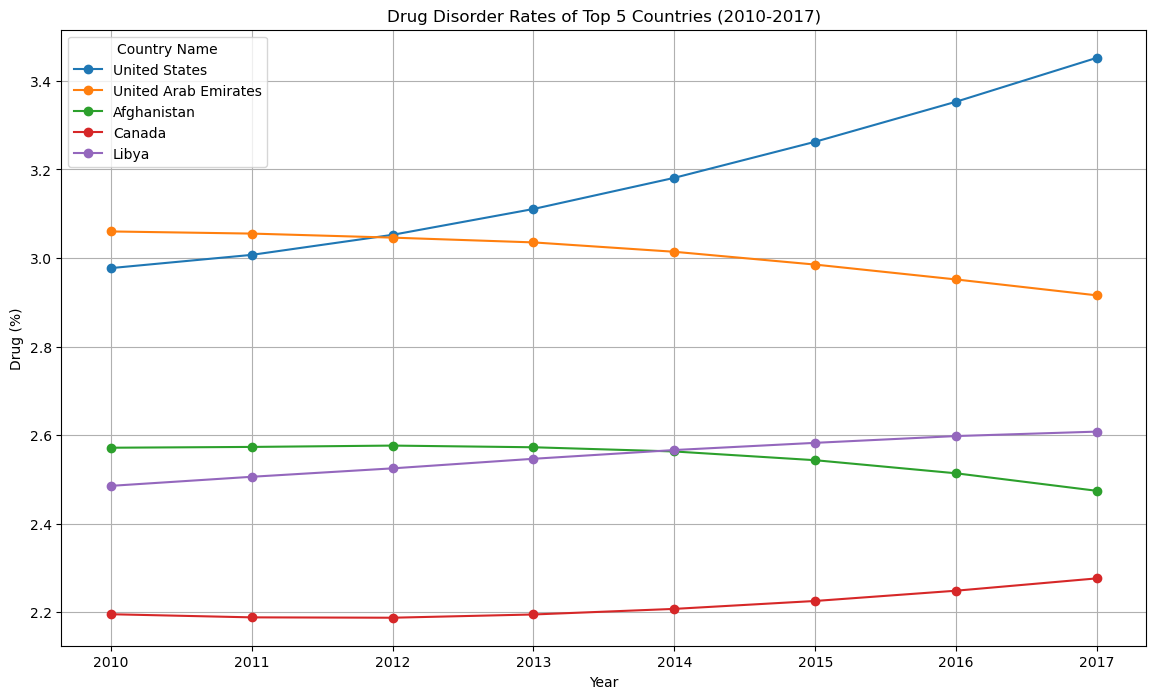

In [19]:
plt.figure(figsize=(14, 8))
for country in Top_Drug_pivot_df.columns:
    plt.plot(Top_Drug_pivot_df.index, Top_Drug_pivot_df[country], marker='o', label=country)
plt.title('Drug Disorder Rates of Top 5 Countries (2010-2017)')
plt.xlabel('Year')
plt.ylabel('Drug (%)')
plt.xticks(Top_Drug_pivot_df.index)
plt.legend(title='Country Name')
plt.grid()
plt.savefig("Output_PNG/Top_Drug_Line.png")
plt.show()


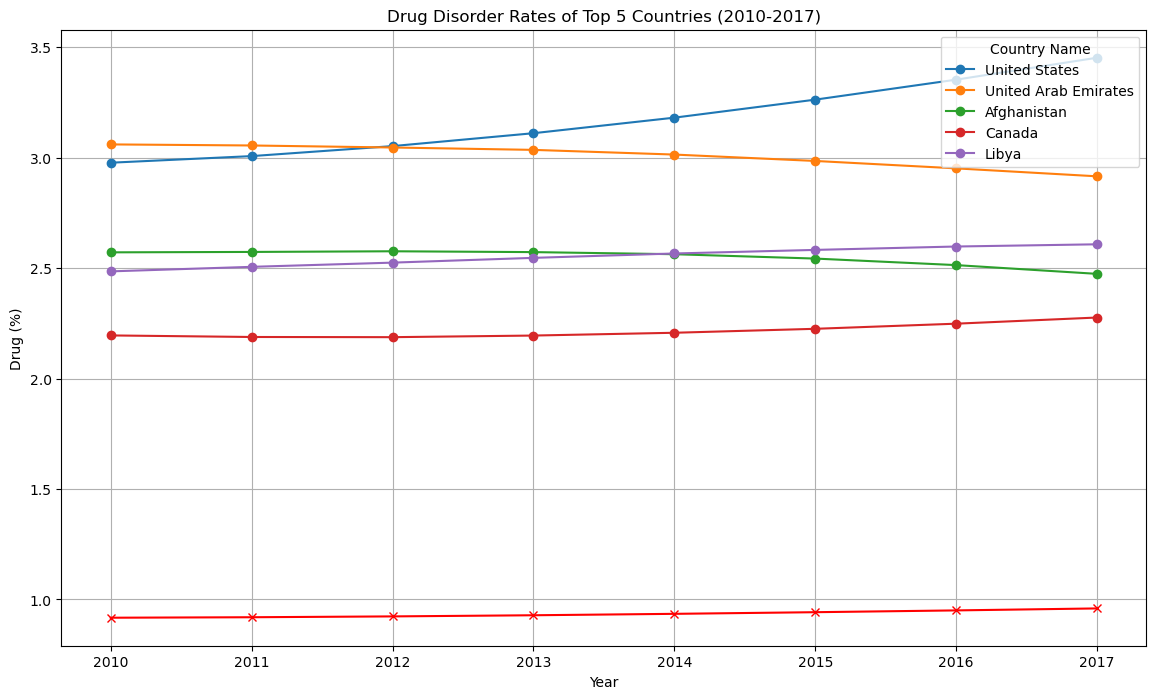

In [20]:
plt.figure(figsize=(14, 8))
for country in Top_Drug_pivot_df.columns:
    plt.plot(Top_Drug_pivot_df.index, Top_Drug_pivot_df[country], marker='o', label=country)
plt.title('Drug Disorder Rates of Top 5 Countries (2010-2017)')
plt.xlabel('Year')
plt.ylabel('Drug (%)')
plt.xticks(Top_Drug_pivot_df.index)
plt.legend(title='Country Name')
plt.grid()
plt.plot(Drug_trend.index, Drug_trend, marker='x', color='red', label='Mean')
plt.savefig("Output_PNG/Top_Drug_Line_withAvg.png")
plt.show()

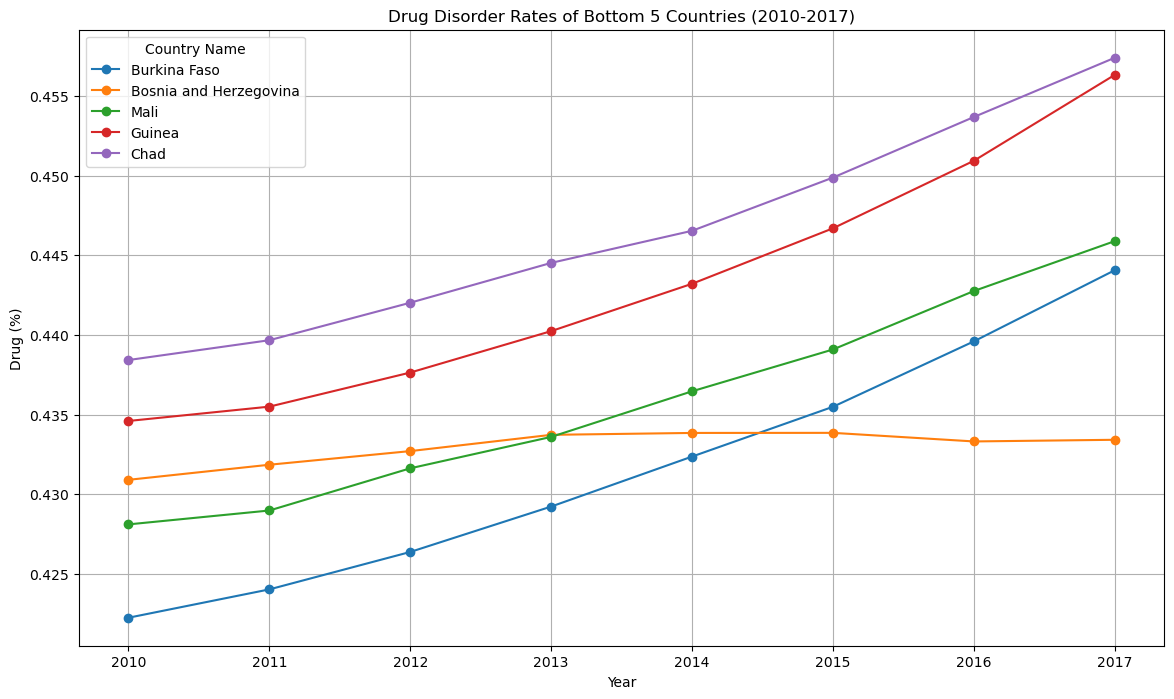

In [21]:
plt.figure(figsize=(14, 8))
for country in Bottom_Drug_pivot_df.columns:
    plt.plot(Bottom_Drug_pivot_df.index, Bottom_Drug_pivot_df[country], marker='o', label=country)
plt.title('Drug Disorder Rates of Bottom 5 Countries (2010-2017)')
plt.xlabel('Year')
plt.ylabel('Drug (%)')
plt.xticks(Bottom_Drug_pivot_df.index)
plt.legend(title='Country Name')
plt.grid()
plt.savefig("Output_PNG/Bottom_Drug_Line.png")
plt.show()


### Drug Use Gov Benefits vs Drug Disorder Rate

In [22]:
Drug_Country_df

,Year,Population,Drug use disorders (%),Drug use disorders (#)
Country Name,,,,
United States,2013.5,3.172709e+08,3.174581,1.008020e+09
United Arab Emirates,2013.5,8.786150e+06,3.007827,2.641824e+07
Libya,2013.5,6.185708e+06,2.552003,1.578635e+07
Afghanistan,2013.5,3.202448e+07,2.548328,8.153747e+07
Canada,2013.5,3.524174e+07,2.215271,7.809234e+07
...,...,...,...,...
Chad,2013.5,1.346250e+07,0.446516,6.017746e+06
Guinea,2013.5,1.122171e+07,0.443142,4.977394e+06
Mali,2013.5,1.734548e+07,0.435812,7.566744e+06


In [23]:
Drug_Country_GovB = pd.merge(Drug_Country_df, Drugs_GovB_MNM, on = 'Country Name', how = 'inner')
Drug_Country_GovB

,Country Name,Year,Population,Drug use disorders (%),Drug use disorders (#),Government Monetary Support,Government Non-Monetary Support
0,United Arab Emirates,2013.5,8.786150e+06,3.007827,2.641824e+07,Yes,Yes
1,Libya,2013.5,6.185708e+06,2.552003,1.578635e+07,No,No
2,Afghanistan,2013.5,3.202448e+07,2.548328,8.153747e+07,No,No
3,Canada,2013.5,3.524174e+07,2.215271,7.809234e+07,Yes,Yes
4,Lebanon,2013.5,5.742400e+06,2.146977,1.235689e+07,No,No
...,...,...,...,...,...,...,...
117,Serbia,2013.5,7.149235e+06,0.449798,3.216076e+06,Yes,Yes
118,Chad,2013.5,1.346250e+07,0.446516,6.017746e+06,No,No
119,Mali,2013.5,1.734548e+07,0.435812,7.566744e+06,No,No
120,Bosnia and Herzegovina,2013.5,3.607821e+06,0.432951,1.561910e+06,Yes,Yes


In [24]:
DrugRate_M_SupportY = Drug_Country_GovB.loc[Drug_Country_GovB['Government Monetary Support'] == 'Yes']['Drug use disorders (%)'].mean()
DrugRate_M_SupportN = Drug_Country_GovB.loc[Drug_Country_GovB['Government Monetary Support'] == 'No']['Drug use disorders (%)'].mean()
DrugRate_NM_SupportY = Drug_Country_GovB.loc[Drug_Country_GovB['Government Non-Monetary Support'] == 'Yes']['Drug use disorders (%)'].mean()
DrugRate_NM_SupportN = Drug_Country_GovB.loc[Drug_Country_GovB['Government Non-Monetary Support'] == 'No']['Drug use disorders (%)'].mean()

print("Average Drug use disorders (%) with Monetary Support (Yes):", DrugRate_M_SupportY)
print("Average Drug use disorders (%) with Monetary Support (No):", DrugRate_M_SupportN)
print("Average Drug use disorders (%) with Non-monetary Support (Yes):", DrugRate_NM_SupportY)
print("Average Drug use disorders (%) with Non-monetary Support (No):", DrugRate_NM_SupportN)

Average Drug use disorders (%) with Monetary Support (Yes): 1.0282884166666666
Average Drug use disorders (%) with Monetary Support (No): 0.7790587060810811
Average Drug use disorders (%) with Non-monetary Support (Yes): 0.9902847670454544
Average Drug use disorders (%) with Non-monetary Support (No): 0.8132776730769231


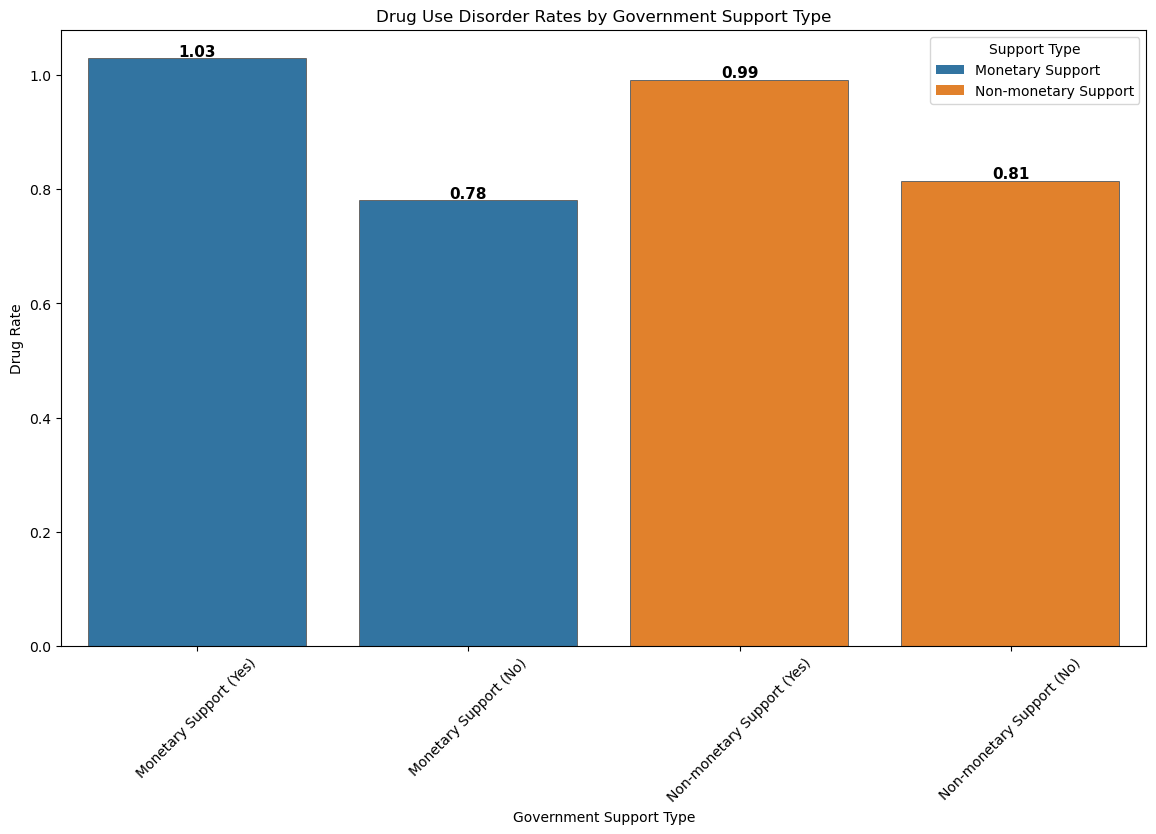

In [25]:
x_axis = ('Monetary Support (Yes)', 
           'Monetary Support (No)', 
           'Non-monetary Support (Yes)', 
           'Non-monetary Support (No)')
GovB = [DrugRate_M_SupportY, DrugRate_M_SupportN, DrugRate_NM_SupportY, DrugRate_NM_SupportN]

# Create a DataFrame
data = pd.DataFrame({
    'Government Support Type': x_axis,
    'Drug Use Disorder Rate (%)': GovB 
})

# Create a new column for grouping
data['Support Type'] = ['Monetary Support']*2 + ['Non-monetary Support']*2

# Set the figure size
bar = plt.figure(figsize=(14, 8))
bars = plt.bar(x_axis, GovB, color='royalblue', alpha=0.7, edgecolor='black', linewidth=1.2)

# Create the bar plot with customized colors
custom_colors = ['#1f77b4', '#ff7f0e']
sns.barplot(data=data, x='Government Support Type', y='Drug Use Disorder Rate (%)', hue = 'Support Type', palette=custom_colors)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), 
             ha='center', va='bottom', fontsize=11, fontweight='bold')


# Show the plot
plt.title('Drug Use Disorder Rates by Government Support Type')
plt.xlabel('Government Support Type')
plt.ylabel('Drug Rate')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.legend(title='Support Type')
plt.savefig("Output_PNG/GovB_Drugs.png", dpi=300, bbox_inches='tight')
plt.show()

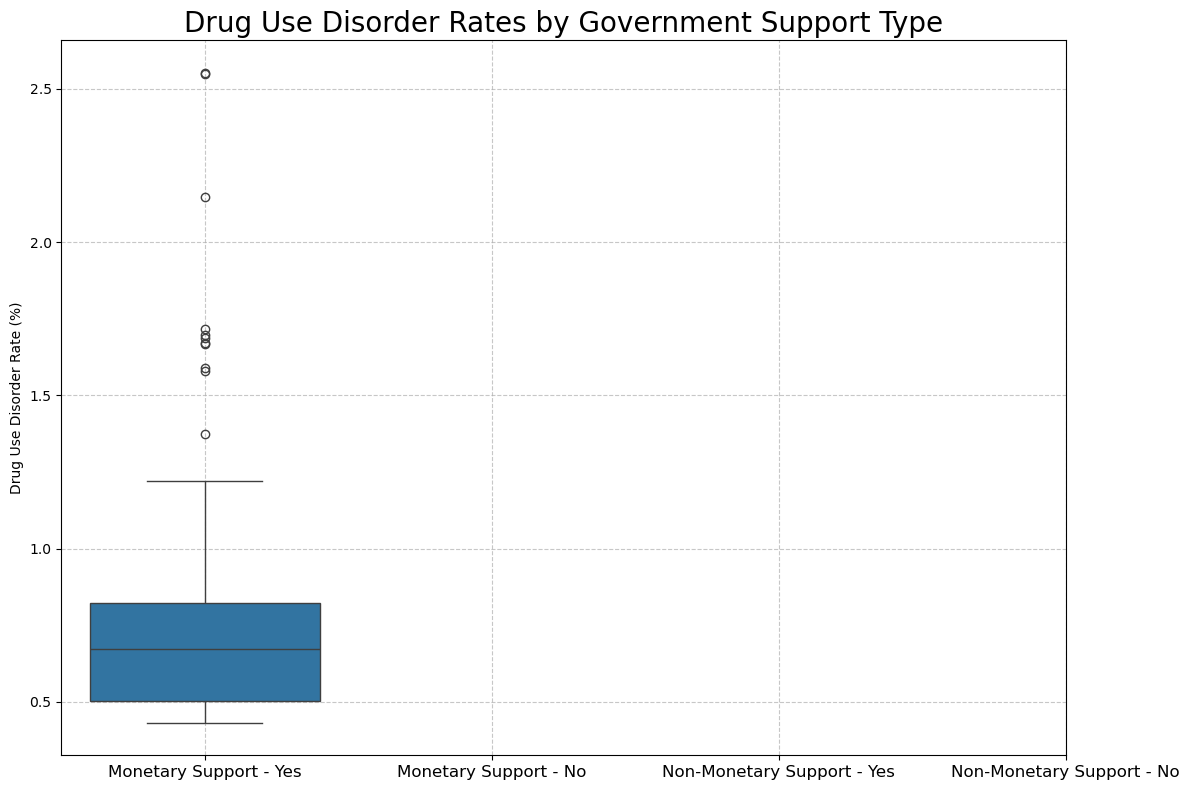

In [37]:
Monetary_yes= Drug_Country_GovB.loc[Drug_Country_GovB['Government Monetary Support'] == 'Yes']['Drug use disorders (%)']
Monetary_no = Drug_Country_GovB.loc[Drug_Country_GovB['Government Monetary Support'] == 'No']['Drug use disorders (%)']
NonMonetary_yes = Drug_Country_GovB.loc[Drug_Country_GovB['Government Non-Monetary Support'] == 'Yes']['Drug use disorders (%)']
NonMonetary_no = Drug_Country_GovB.loc[Drug_Country_GovB['Government Non-Monetary Support'] == 'No']['Drug use disorders (%)']

plt.figure(figsize=(12,8))
sns.boxplot(data=[Monetary_yes, Monetary_no, NonMonetary_yes, NonMonetary_no])
plt.xticks([0,1,2,3], ['Monetary Support - Yes', 'Monetary Support - No', 'Non-Monetary Support - Yes', 'Non-Monetary Support - No'], fontsize = 12)
plt.title('Drug Use Disorder Rates by Government Support Type', fontsize = 20)
plt.ylabel('Drug Use Disorder Rate (%)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('Output_PNG/GovBType_Drugs.png', dpi = 300, bbox_inches = 'tight')
plt.show()

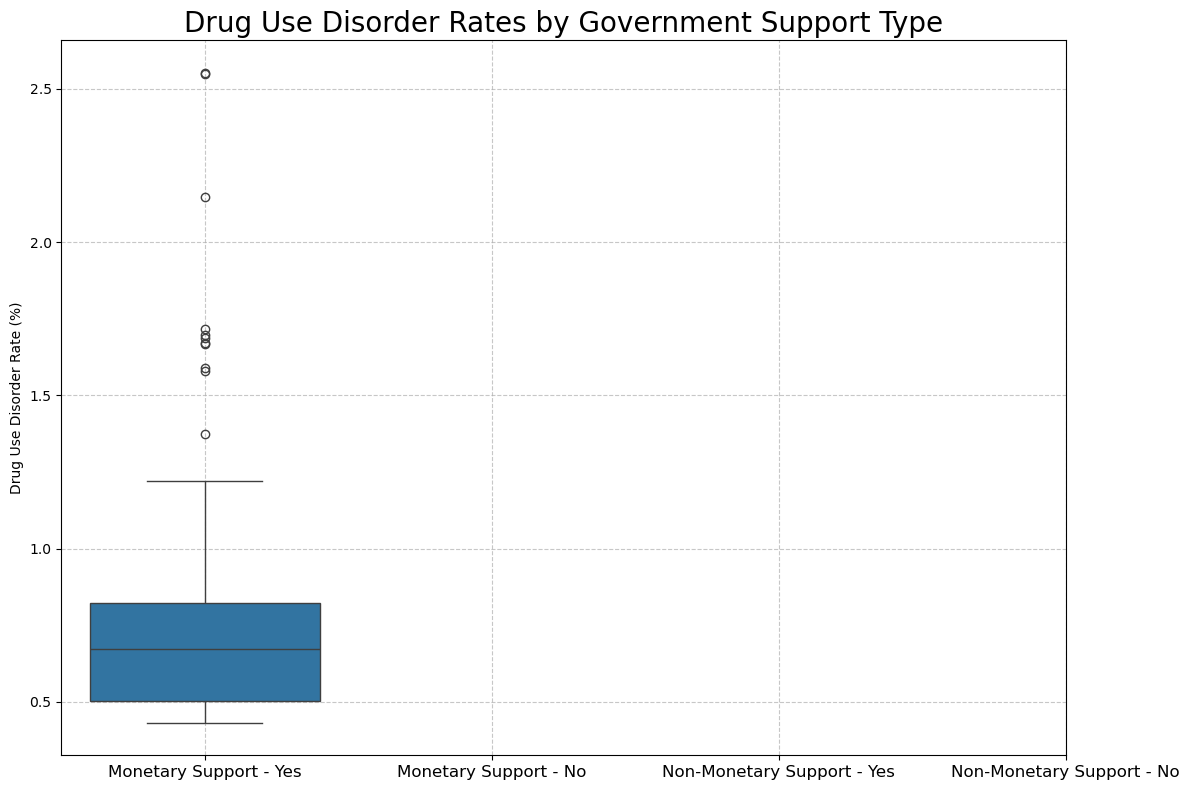

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming the data is already defined as in your provided code
Monetary_yes = Drug_Country_GovB.loc[Drug_Country_GovB['Government Monetary Support'] == 'Yes']['Drug use disorders (%)']
Monetary_no = Drug_Country_GovB.loc[Drug_Country_GovB['Government Monetary Support'] == 'No']['Drug use disorders (%)']
NonMonetary_yes = Drug_Country_GovB.loc[Drug_Country_GovB['Government Non-Monetary Support'] == 'Yes']['Drug use disorders (%)']
NonMonetary_no = Drug_Country_GovB.loc[Drug_Country_GovB['Government Non-Monetary Support'] == 'No']['Drug use disorders (%)']

plt.figure(figsize=(12, 8))

# Create a boxplot with correct data
sns.boxplot(data=[Monetary_yes, Monetary_no, NonMonetary_yes, NonMonetary_no])

# Adjust xticks to match the number of datasets
plt.xticks(ticks=[0, 1, 2, 3], 
           labels=['Monetary Support - Yes', 
                   'Monetary Support - No', 
                   'Non-Monetary Support - Yes', 
                   'Non-Monetary Support - No'], 
           fontsize=12)

plt.title('Drug Use Disorder Rates by Government Support Type', fontsize=20)
plt.ylabel('Drug Use Disorder Rate (%)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('Output_PNG/GovBType_Drugs.png', dpi=300, bbox_inches='tight')
plt.show()


In [40]:
Monetary_yes.mean()

1.0282884166666666

### NYT API

In [26]:
url = "https://api.nytimes.com/svc/search/v2/articlesearch.json?"

query = "Drug disorder"

# Search for articles published between a begin and end date
begin_date = "20100101"
end_date = "20171231"

query_url = f"{url}api-key={api_key}&q={query}&begin_date={begin_date}&end_date={end_date}"

# Request articles
articles = requests.get(query_url).json()

# The "response" property in articles contains the actual articles
# list comprehension.
articles_list = articles["response"]["docs"]
pprint(articles_list)

[{'_id': 'nyt://article/8e1a11bb-9d1e-51f2-8592-c75c069b235f',
  'abstract': 'In a Norwegian study, pregnant women who took acetaminophen for '
              '29 days or more had a more than twofold risk of having children '
              'with A.D.H.D.',
  'byline': {'organization': None,
             'original': 'By Perri Klass, M.d',
             'person': [{'firstname': 'Perri',
                         'lastname': 'Klass',
                         'middlename': None,
                         'organization': '',
                         'qualifier': None,
                         'rank': 1,
                         'role': 'reported',
                         'title': None},
                        {'firstname': None,
                         'lastname': None,
                         'middlename': None,
                         'organization': '',
                         'qualifier': None,
                         'rank': 2,
                         'role': 'reported',
          

In [27]:
# Retrieve articles
articles = requests.get(query_url).json()
articles_list = articles["response"]["docs"]

for article in articles_list:
    print(f'A snippet from the article: {article["snippet"]}')
    print('---------------------------')

A snippet from the article: In a Norwegian study, pregnant women who took acetaminophen for 29 days or more had a more than twofold risk of having children with A.D.H.D.
---------------------------
A snippet from the article: Depression is a silent, slow motion tsunami of dark breaking over me. I can’t swim from it and don’t believe I can survive its natural withdrawal.
---------------------------
A snippet from the article: The medicine, an antipsychotic drug, has a sensor that will show doctors whether and when patients are taking it. Other medicines will follow, experts say.
---------------------------
A snippet from the article: War veterans, victims of abuse and others deserve a chance to use this drug to heal.
---------------------------
A snippet from the article: The mayor has calmed fears related to Ebola and the Zika viruses, and pushed a mental health program called ThriveNYC.
---------------------------
A snippet from the article: As a child, Rob Sullivan watched his parent

In [28]:
# Print the web_url of each stored article
print("Your Reading List")
for article in articles_list:
    print(article["web_url"])

Your Reading List
https://www.nytimes.com/2017/12/04/well/family/does-an-adhd-link-mean-tylenol-is-unsafe-in-pregnancy.html
https://www.nytimes.com/2017/11/26/well/mind/waiting-for-depression-to-lift.html
https://www.nytimes.com/2017/11/13/health/digital-pill-fda.html
https://www.nytimes.com/2017/11/03/opinion/ecstasy-ptsd.html
https://www.nytimes.com/2017/10/16/nyregion/bill-de-blasio-public-health.html
https://www.nytimes.com/video/us/100000005198256/prison-addiction-parenting.html
https://www.nytimes.com/2017/10/15/us/childhood-trauma-prison-addiction.html
https://www.nytimes.com/2017/09/30/opinion/opioid-addiction-treatment-program.html
https://www.nytimes.com/2017/09/11/well/mind/paxil-antidepressants-suicide.html
https://www.nytimes.com/2017/08/11/us/crime-victims-poll-trump-agenda.html


### HVPlot

In [29]:
# Top 5 Drug Use Disorder Countries

# Load a GeoDataFrame with world boundaries
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Example additional data
data = {
    'country': ["United States of America", "United Arab Emirates", "Libya", "Afghanistan", "Canada"],
    'Drug Use Disorder Rate': [3.174581, 3.007827, 2.552003, 2.548328, 2.215271], }

additional_data = pd.DataFrame(data)

# Merge the additional data with the world GeoDataFrame
world = world.merge(additional_data, how='left', left_on='name', right_on='country')

# Check and print for debugging
print(world[['name', 'Drug Use Disorder Rate']].head())  # Inspect the first few rows
print(world.info()) 

# Drop rows with NaN GDP values
world = world.dropna(subset=['Drug Use Disorder Rate'])

# Ensure that 'Drug Use Disorder Rate' is a float
world['Drug Use Disorder Rate'] = world['Drug Use Disorder Rate'].astype(float)

# Define a color mapping for each country
#color_mapping = {"United States of America": "blue","United Arab Emirates": "white","Libya": "black","Afghanistan": "green","Canada": "red"}

# Create a new column in the GeoDataFrame for colors
#world['color'] = world['name'].map(color_mapping)

# Create a map plot
plot = world.hvplot.polygons(
    geo='geometry',  # Specify geometry for the polygons to plot
    fill='Drug Use Disorder Rate',      # Column for values to visualize
    title='Top 5 Drug Use Disorder Rate Countries',
    #='color',
    #cmap='viridis',  # Color map
    #colorbar=True,
    hover_cols=['name', 'Drug Use Disorder Rate'],
    legend = 'bottom'
)


#plt.savefig("Output_PNG/Top5_Alcohol_Map.png")


# Show the plot
plot


                       name  Drug Use Disorder Rate
0                      Fiji                     NaN
1                  Tanzania                     NaN
2                 W. Sahara                     NaN
3                    Canada                2.215271
4  United States of America                3.174581
<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 177 entries, 0 to 176
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   pop_est                 177 non-null    float64 
 1   continent               177 non-null    object  
 2   name                    177 non-null    object  
 3   iso_a3                  177 non-null    object  
 4   gdp_md_est              177 non-null    int64   
 5   geometry                177 non-null    geometry
 6   country                 5 non-null      object  
 7   Drug Use Disorder Rate  5 non-null      float64 
dtypes: float64(2), geometry(1), int

/var/folders/m6/bhhzzj012vq18r_pf4rv2l640000gn/T/ipykernel_3197/1236186397.py:4: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
/opt/anaconda3/envs/mydev/lib/python3.12/site-packages/dask/dataframe/__init__.py:31: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


:Polygons   [Longitude,Latitude]   (name,Drug Use Disorder Rate)

In [30]:
# Load a GeoDataFrame with world boundaries
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Example additional data
data = {
    'country': ["United States of America", "United Arab Emirates", "Libya", "Afghanistan", "Canada"],  # Ensure these match exactly with 'world' DataFrame
    'Drug Use Disorder Rate': [3.174581, 3.007827, 2.552003, 2.548328, 2.215271], 
}
additional_data = pd.DataFrame(data)

# Merge the additional data with the world GeoDataFrame
world = world.merge(additional_data, how='left', left_on='name', right_on='country')

# Drop rows with NaN Drug Use Disorder Rate values
world = world.dropna(subset=['Drug Use Disorder Rate'])

# Ensure that 'Drug Use Disorder Rate' is a float
world['Drug Use Disorder Rate'] = world['Drug Use Disorder Rate'].astype(float)

# Define a color mapping for each country
color_mapping = {
    "United States of America": "red",
    "United Arab Emirates": "blue",
    "Libya": "green",
    "Afghanistan": "orange",
    "Canada": "purple"
}

# Create a new column in the GeoDataFrame for colors
world['color'] = world['name'].map(color_mapping)

# Create a map plot
plot = world.hvplot.polygons(
    geo='geometry',  # Specify geometry for the polygons to plot
    color='color',  # Use the color column for individual country colors
    title='Top 5 Drug Use Disorder Rate Countries',
    hover_cols=['name', 'Drug Use Disorder Rate'],  # Show country names on hover
    legend='top'  # Position the legend at the top
)

# Show the plot
plot


/var/folders/m6/bhhzzj012vq18r_pf4rv2l640000gn/T/ipykernel_3197/1313146732.py:2: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


:Polygons   [Longitude,Latitude]   (color,name,Drug Use Disorder Rate)

In [31]:
# Load a GeoDataFrame with world boundaries
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Example additional data
data = {
    'country': ["United States of America", "United Arab Emirates", "Libya", "Afghanistan", "Canada"],  # Ensure these match exactly with 'world' DataFrame
    'Drug Use Disorder Rate': [3.174581, 3.007827, 2.552003, 2.548328, 2.215271], 
}
additional_data = pd.DataFrame(data)

# Merge the additional data with the world GeoDataFrame
world = world.merge(additional_data, how='left', left_on='name', right_on='country')

# Drop rows with NaN Drug Use Disorder Rate values
world = world.dropna(subset=['Drug Use Disorder Rate'])

# Ensure that 'Drug Use Disorder Rate' is a float
world['Drug Use Disorder Rate'] = world['Drug Use Disorder Rate'].astype(float)

# Define a color mapping for each country
color_mapping = {
    "United States of America": "red",
    "United Arab Emirates": "blue",
    "Libya": "green",
    "Afghanistan": "orange",
    "Canada": "purple"
}

# Create a new column in the GeoDataFrame for colors
world['color'] = world['name'].map(color_mapping)

# Create a map plot with categorical colors
plot = world.hvplot.polygons(
    geo='geometry',  # Specify geometry for the polygons to plot
    color='color',  # Use the color column for individual country colors
    title='Top 5 Drug Use Disorder Rate Countries',
    hover_cols=['name', 'Drug Use Disorder Rate'],  # Show country names on hover
    legend='top',  # Position the legend at the top
    line_color='black'  # Optional: add outline for better visibility
)

# Show the plot
plot


/var/folders/m6/bhhzzj012vq18r_pf4rv2l640000gn/T/ipykernel_3197/1649854576.py:2: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


:Polygons   [Longitude,Latitude]   (color,name,Drug Use Disorder Rate)

In [32]:
# Top 5 Drug Use Disorder Countries

# Load a GeoDataFrame with world boundaries
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Example additional data
data = {
    'country': ["United States of America", "United Arab Emirates", "Libya", "Afghanistan", "Canada"],  # Ensure these match exactly with 'world' DataFrame
    'Drug Use Disorder Rate': [3.174581, 3.007827, 2.552003, 2.548328, 2.215271], 
}
additional_data = pd.DataFrame(data)

# Merge the additional data with the world GeoDataFrame
world = world.merge(additional_data, how='left', left_on='name', right_on='country')

# Check and print for debugging
print(world[['name', 'Drug Use Disorder Rate']].head())  # Inspect the first few rows
print(world.info()) 

# Drop rows with NaN GDP values
world = world.dropna(subset=['Drug Use Disorder Rate'])

# Ensure that 'Alcohol Use Disorder Rate' is a float
world['Drug Use Disorder Rate'] = world['Drug Use Disorder Rate'].astype(float)

# Create a map plot
plot = world.hvplot.polygons(
    geo='geometry',  # Specify geometry for the polygons to plot
    fill='Drug Use Disorder Rate',      # Column for values to visualize
    title='Top 5 Drug Use Disorder Rate Countries',
    cmap='viridis',  # Color map
    colorbar=True,
    hover_cols=['name', 'Drug Use Disorder Rate']
)


#plt.savefig("Output_PNG/Top5_Alcohol_Map.png")


# Show the plot
plot


/var/folders/m6/bhhzzj012vq18r_pf4rv2l640000gn/T/ipykernel_3197/3716698492.py:4: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


                       name  Drug Use Disorder Rate
0                      Fiji                     NaN
1                  Tanzania                     NaN
2                 W. Sahara                     NaN
3                    Canada                2.215271
4  United States of America                3.174581
<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 177 entries, 0 to 176
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   pop_est                 177 non-null    float64 
 1   continent               177 non-null    object  
 2   name                    177 non-null    object  
 3   iso_a3                  177 non-null    object  
 4   gdp_md_est              177 non-null    int64   
 5   geometry                177 non-null    geometry
 6   country                 5 non-null      object  
 7   Drug Use Disorder Rate  5 non-null      float64 
dtypes: float64(2), geometry(1), int

:Polygons   [Longitude,Latitude]   (name,Drug Use Disorder Rate)

In [33]:
# Top 5 Drug Use Disorder Countries

# Load a GeoDataFrame with world boundaries
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Example additional data
data = {
    'country': ["United States of America", "United Arab Emirates", "Libya", "Afghanistan", "Canada"],
    'Drug Use Disorder Rate': [3.174581, 3.007827, 2.552003, 2.548328, 2.215271], }

additional_data = pd.DataFrame(data)

# Merge the additional data with the world GeoDataFrame
world = world.merge(additional_data, how='left', left_on='name', right_on='country')

# Check and print for debugging
print(world[['name', 'Drug Use Disorder Rate']].head())  # Inspect the first few rows
print(world.info()) 

# Drop rows with NaN GDP values
world = world.dropna(subset=['Drug Use Disorder Rate'])

# Ensure that 'Drug Use Disorder Rate' is a float
world['Drug Use Disorder Rate'] = world['Drug Use Disorder Rate'].astype(float)

# Define a color mapping for each country
#color_mapping = {"United States of America": "blue","United Arab Emirates": "orange","Libya": "purple","Afghanistan": "green","Canada": "red"}

color_mapping = {
    "United States of America": "#1f77b4",      # Blue
    "United Arab Emirates": "#ff7f0e",          # Orange
    "Libya": "#9467bd",                          # Purple
    "Afghanistan": "#2ca02c",                   # Green
    "Canada": "#d62728"                          # Red
}


# Create a new column in the GeoDataFrame for colors
world['color'] = world['name'].map(color_mapping)

# Create a map plot
plot = world.hvplot.polygons(
    geo='geometry',  # Specify geometry for the polygons to plot
    fill='Drug Use Disorder Rate',      # Column for values to visualize
    title='Top 5 Drug Use Disorder Rate Countries',
    color='color',
    #cmap='viridis',  # Color map
    #colorbar=True,
    hover_cols=['name', 'Drug Use Disorder Rate'],
    legend = 'bottom'
)


#plt.savefig("Output_PNG/Top5_Alcohol_Map.png")


# Show the plot
plot


/var/folders/m6/bhhzzj012vq18r_pf4rv2l640000gn/T/ipykernel_3197/3811951657.py:4: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


                       name  Drug Use Disorder Rate
0                      Fiji                     NaN
1                  Tanzania                     NaN
2                 W. Sahara                     NaN
3                    Canada                2.215271
4  United States of America                3.174581
<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 177 entries, 0 to 176
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   pop_est                 177 non-null    float64 
 1   continent               177 non-null    object  
 2   name                    177 non-null    object  
 3   iso_a3                  177 non-null    object  
 4   gdp_md_est              177 non-null    int64   
 5   geometry                177 non-null    geometry
 6   country                 5 non-null      object  
 7   Drug Use Disorder Rate  5 non-null      float64 
dtypes: float64(2), geometry(1), int

:Polygons   [Longitude,Latitude]   (color,name,Drug Use Disorder Rate)

### Draft Board

In [47]:
Drug_Rate_by_Country.loc[Drug_Rate_by_Country['Country Name'] == 'Canada']

,Country Name,Year,Drug use disorders (%)
29,Canada,2010,2.195180
196,Canada,2011,2.188105
363,Canada,2012,2.187286
530,Canada,2013,2.194620
697,Canada,2014,2.207245
864,Canada,2015,2.225150
1031,Canada,2016,2.248352
1198,Canada,2017,2.276229
